## NewsBERT

This notebook contains the implementation of the newsBERT pretrained model 

<b>Importing libraries</b>

In [1]:
import os
import warnings
import sys

warnings.filterwarnings('ignore')
current_dir = %pwd

parent_dir = os.path.abspath(os.path.join(current_dir, '../..'))
sys.path.append(parent_dir)

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
from src.main.models.transformers import Transformer
from config import config
from src.main.pipeline.functions import clean_text, stop_words_removal
from src.main.utilities.utils import get_dataset, split_train_val_test
import numpy as np

<b>Model defining and dataset preparation</b>

In [ ]:
inputs, targets = get_dataset(one_hot=False)

checkpoint = "uclanlp/newsbert"

training_args = {
    'output_dir': config.RESULTS_DIRECTORY.format(checkpoint),
    'num_train_epochs': 4,
    'per_device_train_batch_size': 12,
    'per_device_eval_batch_size': 12,
    'learning_rate': 2e-5,
    'warmup_steps': 500,
    'weight_decay': 0.02,
    'logging_dir': config.LOGS_PATH.format(checkpoint),
    'logging_steps': 500,
    'evaluation_strategy': 'epoch',
    'save_strategy': 'epoch',
    'load_best_model_at_end': True,
    'metric_for_best_model': 'accuracy'
}

newsBert = Transformer(checkpoint=checkpoint, **training_args)
newsBert.pipeline = [clean_text, stop_words_removal]
inputs = newsBert.run_pipeline(inputs, save=True)
targets = np.vectorize(config.label2id.get)(targets)

<b>Training and testing the model</b>

In [3]:
x_train, x_val, x_test, y_train, y_val, y_test = split_train_val_test(inputs, targets, validation_size=0.2, test_size=0.1)

training_dataset, validation_dataset, test_dataset = (
    newsBert.prepare_dataset(x_train, y_train, x_val, y_val, x_test, y_test)
)
newsBert.fit(training_dataset, validation_dataset)

Map:   0%|          | 0/75407 [00:00<?, ? examples/s]

Map:   0%|          | 0/21546 [00:00<?, ? examples/s]

Map:   0%|          | 0/10773 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.352800,0.331855,0.898264,0.870858,0.850763,0.859376
2,0.271500,0.322653,0.905412,0.883046,0.852859,0.866675
3,0.195300,0.388989,0.907918,0.878149,0.864993,0.871202


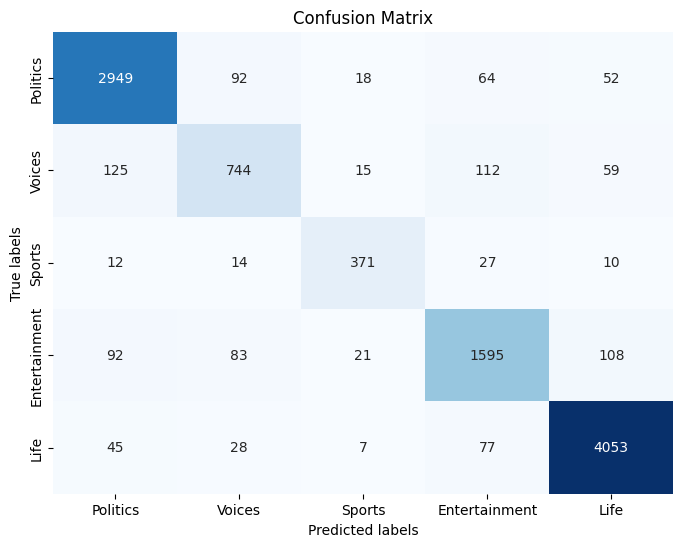

In [4]:
newsBert.save_results(test_dataset)
newsBert.save_model()